# Fraud Detection 
* Author: Grant Gasser
* Last Edit: 8/15/2019
* Kaggle: "In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target `isFraud.`"

## Summary
**This is my first serious attempt at a Kaggle competition. As such, I would really appreciate some feedback or tips for improving performance. If you enjoyed this notebook and it helped you, please leave a thumbs up! Though I've written most of the code myself, I have found the other public kernels very helpful and would encourage you do browse through them to look for other good ideas.**

* **Public Leaderboard Results:** (I plan on using some of the previous submission files for ensembling)
* Random Forest filled NaNs with -999: `.872`
* XGBoost filled NaNs with -999: `.938`, submission file: `baseline_xgboost.csv`
* XGBoost impute mean for numerical NaNs and most common cat for categorical NaNs, also normalized numerical vars: `.878`
* XGBoost impute mean for numerical NaNs and most common cat for categorical NaNs, no normalization: `.932`, submission file: `preprocessed_xgboost`
* XGBoost, impute mean for numerical NaNs, do not impute most common category for categorical NaNs, no normalization: `.934`, file: `preprocessed2_xgboost`. **NOTE**: imputing mean for numerical NaNs and most common category for categorical NaNs did not seem to help for XGBoost. 
* Version 21: hyperparameter tuning with XGBoost (Grid Search or Random Search)

## TODO:
* Possibly more EDA: graph distributions of numerical vars, outlier analysis, etc.
* Maybe Feature Engineering
* Hyperparameter tuning with cross validation

## Libraries

In [1]:
# For data analysis, model building, evaluating
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn import preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 200) # before I forget

import warnings
warnings.filterwarnings("ignore")

#For loading data
import os

# For plots
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

## View provided files

In [2]:
print(os.listdir("../input"))

input_path = '../input'

%matplotlib inline

RANDOM_SEED = 42
nan_replace = -999

['test_identity.csv', 'test_transaction.csv', 'sample_submission.csv', 'train_transaction.csv', 'train_identity.csv']


# Data Description 
* As provided by VESTA: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-586800

#### Transaction Table
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

** Categorical Features: **
* ProductCD
* card1 - card6
* addr1, addr2
* Pemaildomain Remaildomain
* M1 - M9

---

#### Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

** Categorical Features: **
* DeviceType
* DeviceInfo
* id12 - id38

## Load and explore data

In [3]:
%%time
train_identity =  pd.read_csv(os.path.join(input_path, 'train_identity.csv'), index_col='TransactionID')
train_transaction = pd.read_csv(os.path.join(input_path, 'train_transaction.csv'), index_col='TransactionID')
test_identity = pd.read_csv(os.path.join(input_path, 'test_identity.csv'), index_col='TransactionID')
test_transaction = pd.read_csv(os.path.join(input_path, 'test_transaction.csv'), index_col='TransactionID')

CPU times: user 48.5 s, sys: 4.88 s, total: 53.4 s
Wall time: 53.8 s


### View tables

In [4]:
print('train_identity shape:', train_identity.shape)
print('train_transaction shape:', train_transaction.shape)
print('test_identity shape:', test_identity.shape)
print('test_transaction shape:', test_transaction.shape)

train_identity shape: (144233, 40)
train_transaction shape: (590540, 393)
test_identity shape: (141907, 40)
test_transaction shape: (506691, 392)


In [5]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,...,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0

In [6]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


# Merge identity and transaction tables
* Per Kaggle: "The data is broken into two files `identity` and `transaction`, which are joined by `TransactionID`. Not all transactions have corresponding identity information.
* Merge identity and transaction tables with `TransactionID` as the key"
* Since "not all transactions have corresponding identity information," we will use a (left) outer join, using pandas merge function since a key might not appear in both tables

In [7]:
train = pd.merge(train_transaction, train_identity, how='left', on='TransactionID')
test = pd.merge(test_transaction, test_identity, how='left', on='TransactionID')

# see if transaction and identity variables one train table (should be same for test)
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,...,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0

In [8]:
# clear up RAM
del train_transaction, train_identity, test_transaction, test_identity

In [9]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (590540, 433)
test shape: (506691, 432)


In [10]:
num_train = train.shape[0]
num_test = test.shape[0]
num_features = test.shape[1]

print('Test data is {:.2%}'.format(num_test/(num_train+num_test)), 'of total train/test data')

Test data is 46.18% of total train/test data


# Baseline Model with minimal pre-processing (.938)

### XGBoost Classifier
* See [notebook](https://www.kaggle.com/inversion/ieee-simple-xgboost) for starter code

In [11]:
# import xgboost as xgb
# print('XGBoost version:', xgb.__version__)

### Replacing with Missing Values
* Using code from: https://www.kaggle.com/inversion/ieee-simple-xgboost

In [12]:
# y_train = train['isFraud']
# X_train = train.drop('isFraud', axis=1)
# X_test = test


# X_train = X_train.fillna(nan_replace)
# X_test = X_test.fillna(nan_replace)

# del train, test

# # Label Encoding
# for f in X_train.columns:
#     if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(X_train[f].values) + list(X_test[f].values))
#         X_train[f] = lbl.transform(list(X_train[f].values))
#         X_test[f] = lbl.transform(list(X_test[f].values))

## Train XGBoost model

In [13]:
# clf = xgb.XGBClassifier(n_estimators=500,
#     max_depth=9,
#     learning_rate=0.05,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     missing=nan_replace,
#     random_state=RANDOM_SEED,
#     tree_method='gpu_hist')

In [14]:
# %%time
# clf.fit(X_train, y_train)

In [15]:
# sample_submission = pd.read_csv(os.path.join(input_path, 'sample_submission.csv'), index_col='TransactionID')

In [16]:
# del X_train, y_train

In [17]:
# y_pred = clf.predict_proba(X_test)

# sample_submission['isFraud'] = y_pred[:,1]
# sample_submission.to_csv('baseline_xgboost.csv')

### XGBoost AUC = .938

### Data Types
* Before diving into EDA, look at data types of current features and see if they need to be changed

**Categorical Features:**
* ProductCD
* card1 - card6
* addr1, addr2
* Pemaildomain Remaildomain
* M1 - M9
* DeviceType
* DeviceInfo
* id12 - id38

In [18]:
for feature in train.columns[:20]:
    print(feature, '\t', train[feature].dtype)

isFraud 	 int64
TransactionDT 	 int64
TransactionAmt 	 float64
ProductCD 	 object
card1 	 int64
card2 	 float64
card3 	 float64
card4 	 object
card5 	 float64
card6 	 object
addr1 	 float64
addr2 	 float64
dist1 	 float64
dist2 	 float64
P_emaildomain 	 object
R_emaildomain 	 object
C1 	 float64
C2 	 float64
C3 	 float64
C4 	 float64


### Thoughts
* Some of these should not be numerical data (e.g. card1-card6 should be 'object' types, not int64 or float64)
* The next few cells changes this

In [19]:
cat_features = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'isFraud']

# add card1-card6
for i in range(1, 7):
    cat_features.append('card'+str(i))
    
    
# add M1-M9
for i in range(1, 10):
    cat_features.append('M'+str(i))
    
    
# add id12-38
for i in range(12, 39):
    cat_features.append('id_'+str(i))

In [20]:
# Convert categorical features to data type 'object'
def convert_to_object(df, cat_features):
    """
    Converts features to data type 'object', so that all categorical features in dataframe are of type 'object'
    
    Args:
        df (pd.Dataframe)
        cat_features (list): the categorical features as strings
        
    Returns:
        df (pd.Dataframe): where new df has categorical features as type 'object'
    """
    for feature in cat_features:
        if feature not in df.columns:
            print('ERROR:', feature)
        else:
            df[feature] = df[feature].astype('object')
                        
    return df

In [21]:
train = convert_to_object(train, cat_features)
test = convert_to_object(test, cat_features)

#Verify
for feature in train.columns[:20]:
    print(feature, '\t', train[feature].dtype)
    
print('\n')
print('-'*50)
print('\nTest: \n')

for feature in test.columns[:20]:
    print(feature, '\t', test[feature].dtype)

ERROR: isFraud
isFraud 	 object
TransactionDT 	 int64
TransactionAmt 	 float64
ProductCD 	 object
card1 	 object
card2 	 object
card3 	 object
card4 	 object
card5 	 object
card6 	 object
addr1 	 object
addr2 	 object
dist1 	 float64
dist2 	 float64
P_emaildomain 	 object
R_emaildomain 	 object
C1 	 float64
C2 	 float64
C3 	 float64
C4 	 float64


--------------------------------------------------

Test: 

TransactionDT 	 int64
TransactionAmt 	 float64
ProductCD 	 object
card1 	 object
card2 	 object
card3 	 object
card4 	 object
card5 	 object
card6 	 object
addr1 	 object
addr2 	 object
dist1 	 float64
dist2 	 float64
P_emaildomain 	 object
R_emaildomain 	 object
C1 	 float64
C2 	 float64
C3 	 float64
C4 	 float64
C5 	 float64


# EDA

## Check Missing Values
* Hint: there are lots of them

In [22]:
train.isnull().sum()[:15]

isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
dtype: int64

In [23]:
test.isnull().sum()[:15]

TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8654
card3               3002
card4               3086
card5               4547
card6               3007
addr1              65609
addr2              65609
dist1             291217
dist2             470255
P_emaildomain      69192
R_emaildomain     370821
dtype: int64

## Analyze Categorical Variables

In [24]:
for feature in train.columns[:20]:
    if train[feature].dtype == 'object':
        print(feature, '\t Unique categories:', train[feature].describe()[1])
        print('-'*40)

isFraud 	 Unique categories: 2
----------------------------------------
ProductCD 	 Unique categories: 5
----------------------------------------
card1 	 Unique categories: 13553
----------------------------------------
card2 	 Unique categories: 500.0
----------------------------------------
card3 	 Unique categories: 114.0
----------------------------------------
card4 	 Unique categories: 4
----------------------------------------
card5 	 Unique categories: 119.0
----------------------------------------
card6 	 Unique categories: 4
----------------------------------------
addr1 	 Unique categories: 332.0
----------------------------------------
addr2 	 Unique categories: 74.0
----------------------------------------
P_emaildomain 	 Unique categories: 59
----------------------------------------
R_emaildomain 	 Unique categories: 60
----------------------------------------


### Thoughts
* There are several categorical variables with many categories, suggesting that 1-Hot encoding might be too high dimensional
* It may be more prudent to do label encoding (1,2,3,..) to limit dimensionality
* Drawback with Label Encoding: softly implies there is some order to the categories since the categories are now numbered

## Explore Labels
* Note the class imbalance
* About 3.5% of train examples are fraudulent

In [25]:
y_train = train.isFraud
train = train.drop(['isFraud'], axis=1)
num_fraud = y_train.sum()

print('# of fraudulent transactions:', num_fraud, '\n# of training examples:', num_train)

# of fraudulent transactions: 20663 
# of training examples: 590540


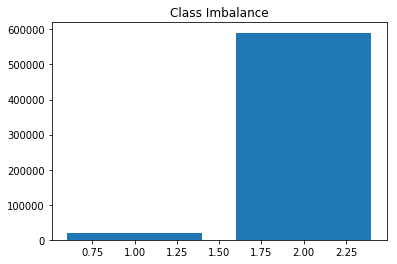

In [26]:
plt.bar([1, 2], height=[num_fraud, num_train])
plt.title('Class Imbalance')
plt.show()

## Compare fraud and non-fraud (within training set)
1. Compare the difference in means of numerical features between the fraud and non-fraud transactions. 

2. Compare the difference in distributions of categorical features between the fraud and non-fraud transactions. 
 

### Look at a few fraudulent transactions

In [27]:
train_fraud = train[y_train == 1]
train_not_fraud = train[y_train == 0]

train_fraud.head(10)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,...,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987203,89760,445.000,W,18268,583,150,visa,226,credit,251,87,NaN,NaN,aol.com,NaN,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,57.0,52.0,0.0,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,374.0,NaN,NaN,NaN,M0,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,90193,37.098,C,13413,103,185,visa,137,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,169947.0,0.0,0.0,3.0,0.0,NaN,NaN,0.0,0.0,100.000000,NotFound,NaN,NaN,Found,Found,225,NaN,266,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987243,90246,37.098,C,13413,103,185,visa,137,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,222455.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.000000,NotFound,43,NaN,Found,Found,225,NaN,266,325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
2987245,90295,37.098,C,13413,103,185,visa,137,credit,NaN,NaN,NaN,N

In [28]:
def get_mean_of_feature(df, feature):
    """
    Calculates and returns mean value of a numerical feature variable
    
    Args:
        df (pd.DataFrame): the dataframe
        feature (str): the name of the numerical feature/variable as a string
        
    Returns:
        mean (float)
    """
    return df[feature].mean()

def get_categorical_distribution_of_feature(df, feature):
    """
    Calculates and returns distribution of a categorical feature variable
    
    Args:
        df (pd.DataFrame): the dataframe
        feature (str): the name of the categorical feature/variable as a string
        
    Returns:
        categorical dist (pd.Series)
    """
    return df[feature].value_counts() / df[feature].value_counts().sum()

In [29]:
def compare_dataframes(df1, df1_description, df2, df2_description):
    """
    Analyze each feature and compare the difference between fraud and not fraud table
    
    Args:
        train_fraud (pd.DataFrame): contains the fraudulent transactions
        train_not_fraud (pd.DataFrame): contains the non-fraud transactions
        
    Returns:
        
    """
    
    # features that look interesting from visual inspection
    features = ['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 
                'P_emaildomain', 'R_emaildomain', 'id_29', 'id_30', 'id_31', 'DeviceType', 'DeviceInfo']
    
    # Use this if analyzing ALL features of dataframes
    # make sure have same features in both dataframes
    #assert(sorted(train_not_fraud.columns) == sorted(train_fraud.columns))
    #features = train_fraud.columns 
    
    for feature in features:
        # numerical feature
        if df1[feature].dtype == 'int64' or df1[feature].dtype == 'float64':
            print('\nNumerical feature (' + str(df1_description), ')\tFeature name:', feature, '\nmean:', get_mean_of_feature(df1, feature))
            print('\nNumerical feature (' + str(df2_description), ')\tFeature name:', feature, '\nmean:', get_mean_of_feature(df2, feature))
        # categorical feature
        elif df1[feature].dtype == 'object': # object, a string
            print('\nCategorical feature(' + str(df1_description), ')\tFeature name:', feature, '\nDistribution:\n', get_categorical_distribution_of_feature(df1,feature)[:10])
            print('\nCategorical feature(' + str(df2_description), ')\tFeature name:', feature, '\nDistribution:\n', get_categorical_distribution_of_feature(df2,feature)[:10])

In [30]:
compare_dataframes(train_fraud, 'Train Fraud', train_not_fraud, 'Train Not Fraud')


Numerical feature (Train Fraud )	Feature name: TransactionDT 
mean: 7690033.087983352

Numerical feature (Train Not Fraud )	Feature name: TransactionDT 
mean: 7360791.131031784

Numerical feature (Train Fraud )	Feature name: TransactionAmt 
mean: 149.2447785897534

Numerical feature (Train Not Fraud )	Feature name: TransactionAmt 
mean: 134.51166457896034

Categorical feature(Train Fraud )	Feature name: ProductCD 
Distribution:
 W    0.434061
C    0.387553
H    0.076175
R    0.069012
S    0.033199
Name: ProductCD, dtype: float64

Categorical feature(Train Not Fraud )	Feature name: ProductCD 
Distribution:
 W    0.755779
C    0.106183
R    0.063651
H    0.055187
S    0.019201
Name: ProductCD, dtype: float64

Categorical feature(Train Fraud )	Feature name: card1 
Distribution:
 9633     0.035910
9500     0.025553
15885    0.021488
9026     0.019213
15063    0.015438
5812     0.015196
2616     0.015196
15066    0.015148
9917     0.014809
6019     0.014228
Name: card1, dtype: float64

Cat

In [31]:
# Clear up RAM (10.3GB -> 8.6GB)
del train_fraud, train_not_fraud

## Compare train and test

In [32]:
compare_dataframes(train, 'Train set', test, 'Test set')


Numerical feature (Train set )	Feature name: TransactionDT 
mean: 7372311.310116165

Numerical feature (Test set )	Feature name: TransactionDT 
mean: 26929937.228952162

Numerical feature (Train set )	Feature name: TransactionAmt 
mean: 135.02717637293821

Numerical feature (Test set )	Feature name: TransactionAmt 
mean: 134.7255682579015

Categorical feature(Train set )	Feature name: ProductCD 
Distribution:
 W    0.744522
C    0.116028
R    0.063838
H    0.055922
S    0.019690
Name: ProductCD, dtype: float64

Categorical feature(Test set )	Feature name: ProductCD 
Distribution:
 W    0.712440
C    0.136703
R    0.070353
H    0.057970
S    0.022534
Name: ProductCD, dtype: float64

Categorical feature(Train set )	Feature name: card1 
Distribution:
 7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
12695    0.012008
12544    0.011469
6019     0.011466
2803     0.010399
7585     0.009032
Name: card1, dtype: float64

Categorical feature(Test set )	

### Note TransactionDT has no overlap
* As mentioned: https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda
* Not sure what to do here. Maybe transform so that each value is relative to its range?

Text(0.5, 1.0, 'Distribution of TransactionDT dates')

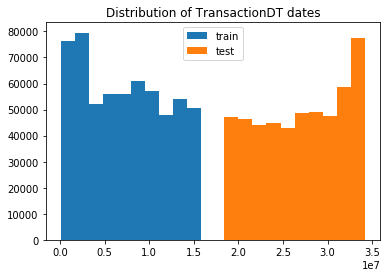

In [33]:
plt.hist(train['TransactionDT'], label='train')
plt.hist(test['TransactionDT'], label='test')
plt.legend()
plt.title('Distribution of TransactionDT dates')

In [34]:
# could correct for time difference in later iteration, for now, just drop column
train.drop(['TransactionDT'], axis=1)
test.drop(['TransactionDT'], axis=1)

print('dropped TransactionDT')

dropped TransactionDT


## Takeaways from EDA
### There are lots of missing values
### There is significant class imbalance (Only ~20,000 out of 590,000 are fraudulent, or 3.5 %)
* Thus, a classifier that always predicts not fraud (0) would have 96.5% accuracy (on the training set, the test set is similar)


### TRAIN SET: Comparing means of numerical features among fraud and non-fraud transactions:
* `TransactionDT` - fraudulent transactions 4.5% higher
* `TransactionAmt` - fraudulent transactions 11% more expensive

### TRAIN SET: Comparing distributions of categorical variables among fraud and non-fraud transactions:
* Take a look at the above cell to see the comparison
* Some of these may spurious, but with 20,000 fraudulent examples, they could imply something
* `ProductCD` - 39% of fraud transactions are 'C', but only 11% of non-fraud transactions are 'C'
* `card1` - looks similar
* `card4` - distribution looks similar
* `card6` - fraud transactions distributed evenly (52/48) between debit and credit whereas non-fraud transactions are mostly debit (76%)
* `P_emaildomain` - 13% of fraud comes from hotmail email vs. 9% non-fraud is hotmail email 
* `R_emaildomain` - 60% of emails on receiving end of fraud are gmail vs. only 40% for non-fraud
* `id_29` - 70% are 'Found' in the fraud examples vs. 52% in the non-fraud
* `id_30` - Though MAC OS versions show up on non-fraud top 10, do not show up in top 10 for fraud, implying fraud less common on MAC
* `DeviceType` - fraud was about evenly distributed (50/50) between mobile and desktop, most non-fraud on desktop (61%)
* `DeviceInfo` - similar to what id_30 implied, MAC used for 11% of non-fraud transactions but just 3% of fraud transactions


### Comparing train distribution and test distribution
* Remember, train size is $560,000$ and test size is $500,000$
* Other than `TransactionDT`, the distributions look similar
* Note that since the test set is later in time, there are some features where the distributions are almost certain to be different
* e.g. `id_31` represents the browser used. For the train set, the most common browser was **chrome 63** at 16%. In the test set, the most common was **chrome 70**.
7 versions later and **chrome 63** did not even show up in the top 10 most common browser for the test set, unsurprisingly.
* Should I drop `id_31` and other columns affected by time or let the model weight it?
* Also, looking at `DeviceType`, 60% of transactions in the train set were done on desktop vs. 54% on desktop in test set. 
Could this represent the increasing usage of mobile? Is there that much of a time difference between the train and test set?

# Pre-processing

### Remove features with large amounts of missing data
* For computational purposes, removing features that have 80% (arbitrary number) or more missing values in the training set
* May come back and try different values for this cutoff
* Fill in remaining missing values with mean or median

### In next iteration: come back and inspect columns being dropped
* See if some should be kept and receive imputed values

In [35]:
drop_cols = [c for c in train.columns if (train[c].isnull().sum() /  num_train) > .80]

# also dropping V107 (though float values and VESTA did not say it was categorical, it really looks categorical in {0,1})
# it caused problems in making predictions, after further analysis, it seemed to have weak correlation with target variable
drop_cols.append('V107')

print('Dropping', len(drop_cols), 'columns.')
print('Including...', drop_cols[0:10])

Dropping 75 columns.
Including... ['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139']


In [36]:
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

## Replace missing values with mean (numerical) and most common category (categorical)

 ### Reminder
 **NOTE:** with fillna, replace and other pandas functions, make sure you set the variable, because it returns the transformed object
 * e.g. `df[feature] = df[feature].replace()` instead of just `df[feature].replace()`
 * **Note:** Just replacing NaNs with -999 and letting XGBoost handle it, will use this function if try different models such as Neural Network

In [37]:
def replace_nans(df):
    """
    Replaces missing values (NaNs) with the mean (if numerical) and with most
    common category (if categorical)
    
    Args:
        df (pd.DataFrame)
        
    Returns:
        df (pd.DataFrame): transformed dataframe
    """
    # NOTE: fillna did not work well here, recommend using replace
    
    for feature in df.columns:
        # replace categorical variable with most frequent
        if df[feature].dtype == 'object':
            df[feature] = df[feature].replace(np.nan, df[feature].value_counts().index[0])
        
        # replace NaN in numerical columns with mean (could try median)
        else:
            df[feature] = df[feature].replace(np.nan, df[feature].mean()) # most common category
            
    return df

In [38]:
# train = replace_nans(train)
# test = replace_nans(test)

# fill in -999 where vars have NaNs
train = train.replace(np.nan, nan_replace)
test = test.replace(np.nan, nan_replace)

### Any remaining missing values?

In [39]:
train.head() # nice and pretty

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,...,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,-999.0,150.0,discover,142.0,credit,315.0,87.0,19.0,-999,-999,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,13.0,13.0,0.0,T,T,T,M2,F,T,-999,-999,-999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999,-999,-999.0,-999.0,-999.0,-999,-999,-999,-999,-999,-999,-999,-999,-999
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,-999.0,gmail.com,-999,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999,-999,-999,M0,T,T,-999,-999,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999,-999,-999.0,-999.0,-999.0,-999,-999,-999,-999,-999,-999,-999,-999,-999
2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,-999,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,0.0,315.0,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1

In [40]:
train.isnull().sum().sum() # 0

0

In [41]:
test.isnull().sum().sum() # 0

0

## Label Encoding
* Change categorical variable data to numbers so that computer can understand
* e.g. if the encoding is: `['mastercard', 'discover', 'visa']` based on index, then data like `['visa', 'visa', 'mastercard', 'discover', 'mastercard']` would be encoded as `[2, 2, 0, 1, 0]`

In [42]:
%%time
from sklearn.preprocessing import LabelEncoder

# When trying to encode variabels, receive the following ValueError: y contains previously unseen labels: [nan, nan, nan,... , nan]
for feature in train.columns:
    if train[feature].dtype == 'object' or test[feature].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[feature].values) + list(test[feature].values))
        train[feature] = le.transform(list(train[feature].values))
        test[feature] = le.transform(list(test[feature].values))

CPU times: user 44 s, sys: 8 ms, total: 44 s
Wall time: 44.1 s


In [43]:
# Don't see any strings here, looks like the encoding worked
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,...,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,4,13926,-999.0,150.0,2,142.0,2,315.0,87.0,19.0,0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,13.0,13.0,0.0,2,2,2,3,1,2,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0
2987001,86401,29.0,4,2755,404.0,150.0,3,102.0,2,325.0,87.0,-999.0,17,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,0,0,0,1,2,2,0,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0
2987002,86469,59.0,4,4663,490.0,150.0,4,166.0,3,330.0,87.0,287.0,36,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,0.0,315.0,315.0,2,2,2,1,1,1,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-99

### Normalize Variables
* For speed of convergence and numerical stability
* Also to ensure variables with larger numbers do not dominate the model (e.g. TransactionAmt)
* Normalize numerical variables: $x_{i,j} = \frac{x_{i,j} - \mu_j}{\sigma_j}$ where $i$ is the row, $j$ is the column, $\mu_j$ is the mean of the column and $\sigma_j$ is the std of the col
* After the transformation, we will have $\mu_j = 0$ and $\sigma_j = 1$ for each numerical column/feature $j$
* Could also try Min-Max scaling too which gives $x_j \in (0,1)$ for all $i$.

In [44]:
def normalize(df):
    """
    Normalize numerical variables
    
    Args:
        df (pd.DataFrame): dataframe to be normalized
        
    Returns:
        df (pd.Dataframe): dataframe where each column has mean 0
    """
    for feature in df.columns:
        if df[feature].dtype != 'object': # if it is numerical
            mu = df[feature].mean()
            sd = df[feature].std()
            df[feature] = (df[feature] - mu) / sd
            
            # verify mean is 0
            mu_after = df[feature].mean()
            #print(feature, mu_after) # checks out
            
    return df
            

## Skip normalize to see effect on performance
* Pre-processed XGBoost score `.878` vs. `.938` with no pre-processing
* **Note:** After removing normalization for XGBoost, performance jumped from `.878` to `.932`. Normalization may only be necessary or helpful with neural nets and similar algorithms

In [45]:
# train = normalize(train)
# test = normalize(test)

### Reduce memory usage before fitting XGBoost
* Thanks to https://www.kaggle.com/iasnobmatsu/xgb-model-with-feature-engineering

In [46]:
print(train.memory_usage().sum() / 1024**3, 'GB')
print(test.memory_usage().sum() / 1024**3, 'GB')

1.5751519799232483 GB
1.3515008836984634 GB


In [47]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [48]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 433.65 Mb (73.1% reduction)
Mem. usage decreased to 378.84 Mb (72.6% reduction)


## XGBoost
* https://developer.ibm.com/code/2018/06/20/handle-imbalanced-data-sets-xgboost-scikit-learn-python-ibm-watson-studio/
* XGBoost is an extreme gradient boosting algorithm based on trees that tends to perform very well out of the box compared to other ML algorithms.
* XGBoost is popular with data scientists and is one of the most common ML algorithms used in Kaggle Competitions.
* XGBoost allows you to tune various parameters.
* XGBoost allows parallel processing.

## Fit the XGBoost Classifier Again using Cross Validation
* See how the performance differs after imputing values and normalizing data
* The baseline score was `.938`

In [49]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

### Hyperparameter tuning with GridSearch and RandomizedSearch
* [XGBoost parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)
* [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) - **Takes too much RAM**, exhaustive search of the parameters, expensive but finds the optimal set
* set `scale_pos_weight` to adjust for class imbalance, common to do `sum(neg samples) / sum(pos samples)` which would be about 30 in this data set
* control overfitting: `max_depth`, `min_child_weight`, `gamma` per xgboost docs

## TODO
* GridSearchCV and RandomizedSearchCV take too much RAM
* Will write my own grid search loop and be more efficient with RAM

In [50]:
y = y_train.astype('category')

In [51]:
# grid of parameters, use GridSearch to find best combination
n_estimators = [250, 500, 750]
learning_rate = [.05, .1, .3]
max_depth = [6, 8, 10]
reg_lambda = [.1, 1, 3] # L2

In [52]:
# import time

# start = time.time()

# # try all combinations of parameters
# for n_est in n_estimators:
#     for lr in learning_rate:
#         for md in max_depth:
#             for l2 in reg_lambda:
                
#                 # train/test split, hopefully with a large dataset this is sufficient to estimate roc auc
#                 X_train, X_test, y_train, y_valid = train_test_split(train, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
                
#                 # fit
#                 clf = xgb.XGBClassifier(n_estimators=n_est,
#                                         learning_rate=lr,
#                                         max_depth=md,
#                                         reg_lambda=l2,
#                                         missing=nan_replace,
#                                         subsample=.8,
#                                         colsample_bytree=.8,
#                                         scale_pos_weight=20, # to correct for class imbalance
#                                         random_state=RANDOM_SEED,
#                                         tree_method='gpu_hist')
                
#                 # fit with these parameters
#                 clf.fit(X_train, y_train)
#                 del X_train, y_train
                
#                 # predict on test/ estimate roc_auc, pick model with
#                 y_pred = clf.predict_proba(X_test)
#                 del X_test, clf
                
#                 print(roc_auc_score(y_valid, y_pred[:,1]), 'with parameters n_estimators={}, learning_rate={}, max_depth={}, reg_lambda={}'.format(n_est, lr, md, l2))
#                 del y_valid, y_pred
                
#                 now = time.time()
#                 print('ELAPSED TIME:', now-start, 'seconds')
                
#                 print(train.memory_usage().sum() / 1024**3, 'GB')
#                 print(y.memory_usage() / 1024**3, 'GB\n')
                
#                 # train = reduce_mem_usage(train)
                
#                 # give RAM time to clear
#                 time.sleep(10)
                

## Predict with best hyperparameters
* `n_estimators=250, lr=.05, max_depth=10, reg_lambda=3` scored `.96` - since l2=3, hopefully not an overfit

In [53]:
%%time

# define xgboost classifier
clf = xgb.XGBClassifier(n_estimators=250,
                            learning_rate=.05,
                            max_depth=10,
                            reg_lambda=3,
                            missing=nan_replace,
                            subsample=.8,
                            colsample_bytree=.8,
                            scale_pos_weight=20, # to correct for class imbalance
                            random_state=RANDOM_SEED,
                            tree_method='gpu_hist')
    
# fit classifier
clf.fit(train, y_train)
del train, y_train

CPU times: user 12.1 s, sys: 16.5 s, total: 28.6 s
Wall time: 28.8 s


In [54]:
sample_submission = pd.read_csv(os.path.join(input_path, 'sample_submission.csv'), index_col='TransactionID')

y_pred = clf.predict_proba(test)
del clf, test

sample_submission['isFraud'] = y_pred[:,1]
del y_pred
sample_submission.to_csv('xgboost_with_tuning.csv')